In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error

import missingno as msno

from pprint import pprint

import matplotlib.pyplot as plt

In [2]:

def eda_df(df):
    """Провести EDA для датафрейма"""
    df_describe = df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    # посчитать долю пропусков
    df_describe.loc["%nan"] = (df.isna().mean()*100).to_list()
    # посчитать дисперсию
    columns_var = []
    for column in df_describe.columns:
        columns_var.append(df[column].var())
    df_describe.loc['var'] = columns_var
    return df_describe


def remove_outliers(df, columns):
    """Убираем выбросы - добавим новое свойство {column}_without_outliers, 
    в котором выбросы будут заменены на пустые значения"""
    for column in columns:
        Q3 = np.quantile(df[column], 0.75, axis=0)
        Q1 = np.quantile(df[column], 0.25, axis=0)
        IQR = Q3 - Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5 * IQR

        df[f'{column}_without_outliers'] = df[column].map(lambda x: np.nan if x<lower else x if x<=upper else np.nan)

def show_boxes(df, columns, ncols = 3):
    nrows = int(round((len(columns) + 0.5) / ncols, 0))

    fig = make_subplots(rows=nrows, cols=ncols)
    fig.update_layout(
        title_x=0.5,
        title_text="Ящики с усами",
        height=500*nrows, 
        width=1200
    )
    i = 0
    for r in range(nrows):
        for c in range(ncols):
            fig.add_box(y=df[columns[i]], name=columns[i], row=r+1, col=c+1)
            i += 1
            if i >= len(columns):
                break
        if i >= len(columns):
            break
    fig.show()            
    
def train_model(dataset, columns, target_column, param_grid):
    X_train, X_test, y_train, y_test = train_test_split(dataset[columns],
                                                        dataset[target_column],
                                                        stratify=dataset[target_column],
                                                        test_size=0.2, random_state=42)

    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)    
    
    knn_best = KNeighborsClassifier(**grid_search.best_params_)
    knn_best_fit = knn_best.fit(X_train, y_train)
    
    model_cl = KNeighborsClassifier(n_neighbors = knn_best_fit.n_neighbors)
    model_cl.fit(X_train, y_train) # тренировка модели fit

    
    return X_train, X_test, y_train, y_test, grid_search, knn_best, knn_best_fit, model_cl
    
def check_model(X_train, X_test, y_train, y_test, knn_best):
    y_test_pred = knn_best.predict(X_test)
    y_test_prob = knn_best.predict_proba(X_test)[:, 1]
    y_train_pred = knn_best.predict(X_train)
    y_train_prob = knn_best.predict_proba(X_train)[:, 1]
    
    # матрица ошибок
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    
    #Accuracy - доля всех верных предсказаний (как положительных, так и отрицательных) относительно общего числа прогнозов.
    accuracy_score_test = accuracy_score(y_test, y_test_pred)
    accuracy_score_train = accuracy_score(y_train, y_train_pred)
    
    #Precision - доля верных положительных предсказаний среди всех случаев, когда модель предсказала положительный класс.
    precision_score_test = precision_score(y_test, y_test_pred)
    precision_score_train = precision_score(y_train, y_train_pred)

    # Recall - полнота, Способность модели находить все реальные положительные примеры
    recall_score_test = recall_score(y_test, y_test_pred)
    recall_score_train = recall_score(y_train, y_train_pred)
    
    # AUC ROC - Способность модели разделять два класса (например, "больной" vs "здоровый") на всех возможных порогах классификации
    roc_auc_score_test = roc_auc_score(y_test, y_test_prob)
    roc_auc_score_train = roc_auc_score(y_train, y_train_prob)
    
    result = {'y_test_pred': y_test_pred, 
              'y_test_prob': y_test_prob, 
              'y_train_pred': y_train_pred, 
              'y_train_prob': y_train_prob,
              'conf_matrix_test': conf_matrix_test, 
              'conf_matrix_train': conf_matrix_train, 
              'accuracy_score_test': accuracy_score_test, 
              'accuracy_score_train': accuracy_score_train,
              'precision_score_test': precision_score_test,
              'precision_score_train': precision_score_train,
              'recall_score_test': recall_score_test,
              'recall_score_train': recall_score_train,
              'roc_auc_score_test': roc_auc_score_test,
              'roc_auc_score_train': roc_auc_score_train
              }
    
    return result    

def show_quality(X_train, X_test, y_train, y_test, check_result, title):
    # Матрица ошибок
    r = lambda x: round(x, 3)
    #print("Confusion Matrix Test:")
    #print(f'TN: {check_result['conf_matrix_test'][0][0]:3} | FP: {check_result['conf_matrix_test'][0][1]:3}')
    #print(f'FN: {check_result['conf_matrix_test'][1][0]:3} | TP: {check_result['conf_matrix_test'][1][1]:3}')
    #print()

    #print("Confusion Matrix Train:")
    #print(f'TN: {check_result['conf_matrix_train'][0][0]:3} | FP: {check_result['conf_matrix_train'][0][1]:3}')
    #print(f'FN: {check_result['conf_matrix_train'][1][0]:3} | TP: {check_result['conf_matrix_train'][1][1]:3}')
    #print()

    # Построение ROC кривой
    fpr_test, tpr_test, thresholds = roc_curve(y_test, check_result["y_test_prob"])
    fpr_train, tpr_train, thresholds = roc_curve(y_train, check_result["y_train_prob"])
    fig = go.Figure(data = [go.Scatter(x=fpr_test, y=tpr_test, name="ROC curve Test", line={'color':'blue'},), 
                            go.Scatter(x=fpr_train, y=tpr_train, name="ROC curve Train", line={'color':'green'}),
                            go.Scatter(x=[0, 1], y=[0, 1], line={'color':'gray', 'dash': 'dash'}, showlegend=False)
                        ] )
    fig.update_xaxes(title_text="False Positive Rate")
    fig.update_yaxes(title_text='True Positive Rate')
    
    df_metrics = pd.DataFrame([[check_result["accuracy_score_test"], check_result["accuracy_score_train"]],
                    [check_result["precision_score_test"], check_result["precision_score_train"]],
                    [check_result["recall_score_test"], check_result["recall_score_train"]],
                    [check_result["roc_auc_score_test"], check_result["roc_auc_score_train"]]
                    ], columns = ["Test", "Train"], index=["accuracy", "precision", "recall", "ROC AUC"])
    trace1 = go.Bar(x=df_metrics.index, y=df_metrics.Test, 
                    showlegend=True, text=round(df_metrics.Test,4), textangle=0, 
                    xaxis='x2', yaxis='y2', name="Test Metrics")
    trace2 = go.Bar(x=df_metrics.index, y=df_metrics.Train, 
                    showlegend=True, text=round(df_metrics.Train,4), textangle=0, 
                    xaxis='x2', yaxis='y2', name="Train Metrics")

    fig.add_traces([trace1, trace2]) 

    fig['layout']['xaxis2'] = {}
    fig['layout']['yaxis2'] = {}
    
    # Edit layout for subplots
    fig.layout.xaxis.update({'domain': [0, .5]})
    fig.layout.xaxis2.update({'domain': [0.6, 1.]})    
    # The graph's yaxis MUST BE anchored to the graph's xaxis
    fig.layout.yaxis2.update({'anchor': 'x2'})
    fig.layout.yaxis2.update({'title': 'Goals'})    


    # Update the margins to add a title and see graph x-labels.
    fig.update_layout(
        title_x=0.5,
        title_text=title,
        width = 1200,
        height = 530,
        legend= dict(yanchor="bottom", y=0.01, xanchor="right", x=0.49)
    )    
    
    fig.layout.margin.update({'t':50, 'b':100})

    fig.show()


# 1. Загрузить датасет

In [3]:
# https://www.kaggle.com/competitions/playground-series-s3e12/data
dataset_df = pd.read_csv('dataset/train.csv', index_col="id")

# 2. EDA датасета

In [4]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  414 non-null    float64
 1   ph       414 non-null    float64
 2   osmo     414 non-null    int64  
 3   cond     414 non-null    float64
 4   urea     414 non-null    int64  
 5   calc     414 non-null    float64
 6   target   414 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 25.9 KB


Описание свойств:
* graviti - удельный вес, плотность мочи по отношению к воде;
* pH - рН, отрицательный логарифм иона водорода
* osmo - осмолярность (mOsm) - единица измерения, используемая в биологии и медицине, но не в физической химии. 
Осмолярность пропорциональна концентрации молекул в растворе.
* cond - электропроводность (mMho, миллимехо). Один Mho равен одному обратному Ому. 
Электропроводность пропорциональна концентрации заряженных ионов в растворе;
* urea - концентрация мочевины в миллимолях на литр
* calc - концентрация кальция (CALC) в миллиметровом литре.
* target - целевая переменная

In [5]:
dataset_df.sample(5)

,gravity,ph,osmo,cond,urea,calc,target
id,,,,,,,
291,1.017,5.94,559,15.5,317,6.96,1
262,1.008,5.53,876,27.6,301,6.96,1
326,1.019,5.53,487,20.0,199,3.34,1
21,1.018,5.35,874,29.0,457,4.18,1
96,1.018,5.66,543,21.9,170,1.45,0


In [6]:
dataset_df_describe = eda_df(dataset_df)
dataset_df_describe

,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
10%,1.008000,5.330000,343.600000,10.900000,95.000000,1.053000,0.000000
25%,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
90%,1.025000,6.810000,925.200000,29.000000,443.000000,8.515000,1.000000
max,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


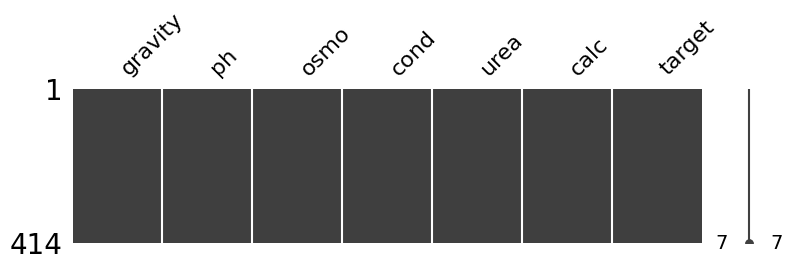

In [7]:
_ = msno.matrix(dataset_df, figsize=(9,2))

Выводы по набору данных:
  * все переменные числовые, с непрерывными значениями
  * пропусков нет ни в тренировочном, ни в тестовом наборе данных

# 3. Доли значений целевой переменной

In [8]:
print(dataset_df["target"].value_counts(normalize=True))

target
0    0.555556
1    0.444444
Name: proportion, dtype: float64


# 4. Графики для анализа

In [9]:
fig = px.imshow(dataset_df.corr(), height=600, width=600, text_auto='.2f' )
fig.show()

Довольно высокая зависимость между osmo-urea (0.81), osmo-cond (0.71 ) и osmo-gravity (0.69).

Это ожидаемо, т.к. чем выше концентрация мочевины, тем больше молекул в единице объема, лучше электропроводность и выше плотность, по сравнению с просто водой.

In [10]:
show_boxes(dataset_df, ["urea", "gravity", "osmo", "calc", "cond", "ph"])

У переменных gravity и ph есть выбросы.

# 5. KNN

## Подготовка датасета к построению моделей

### Выбросы заменить на среднее

In [11]:
remove_outliers(dataset_df, ["gravity", "ph"])
show_boxes(dataset_df, ["gravity", "gravity_without_outliers", "ph", "ph_without_outliers"], ncols=2)

In [12]:
train_df_describe = eda_df(dataset_df[["gravity", "ph", "gravity_without_outliers", "ph_without_outliers"]])
train_df_describe

,gravity,ph,gravity_without_outliers,ph_without_outliers
count,414.000000,414.000000,411.000000,402.000000
mean,1.017894,5.955459,1.017732,5.900771
std,0.006675,0.642260,0.006425,0.566327
min,1.005000,4.760000,1.005000,4.760000
10%,1.008000,5.330000,1.008000,5.276000
25%,1.012000,5.530000,1.012000,5.530000
50%,1.018000,5.740000,1.018000,5.710000
75%,1.022000,6.280000,1.022000,6.270000
90%,1.025000,6.810000,1.025000,6.790000
max,1.040000,7.940000,1.034000,7.380000


In [13]:
# заменим образовавшиеся пропуски 
dataset_df = dataset_df.fillna({"gravity_without_outliers": dataset_df["gravity_without_outliers"].median(), 
                            "ph_without_outliers": dataset_df["ph_without_outliers"].median()})

In [14]:
dataset_df_describe2 = eda_df(dataset_df[["gravity", "ph", "gravity_without_outliers", "ph_without_outliers"]])
dataset_df_describe2

,gravity,ph,gravity_without_outliers,ph_without_outliers
count,414.000000,414.000000,414.000000,414.000000
mean,1.017894,5.955459,1.017734,5.895242
std,0.006675,0.642260,0.006402,0.558959
min,1.005000,4.760000,1.005000,4.760000
10%,1.008000,5.330000,1.008000,5.330000
25%,1.012000,5.530000,1.012000,5.530000
50%,1.018000,5.740000,1.018000,5.710000
75%,1.022000,6.280000,1.022000,6.210000
90%,1.025000,6.810000,1.025000,6.790000
max,1.040000,7.940000,1.034000,7.380000


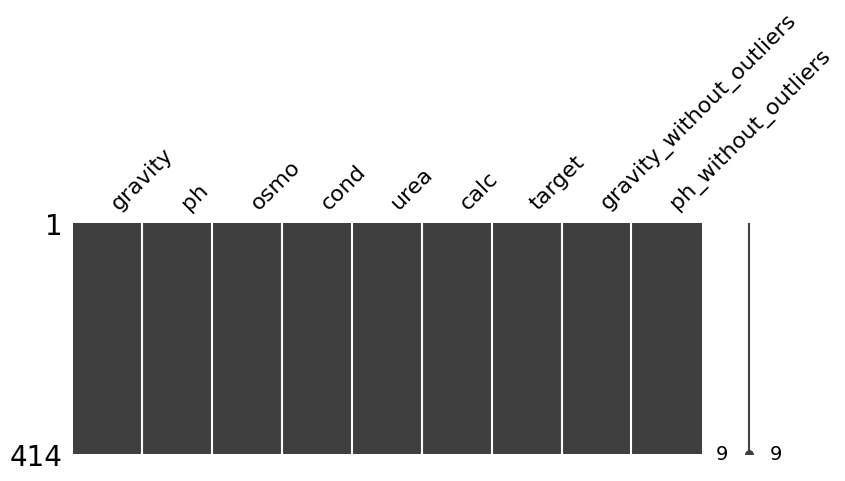

In [15]:
_ = msno.matrix(dataset_df, figsize=(9,3))

## Выполнить нормализацию датасета

In [16]:
dataset_df.head(10)

,gravity,ph,osmo,cond,urea,calc,target,gravity_without_outliers,ph_without_outliers
id,,,,,,,,,
0,1.013,6.19,443,14.8,124,1.45,0,1.013,6.19
1,1.025,5.40,703,23.6,394,4.18,0,1.025,5.40
2,1.009,6.13,371,24.5,159,9.04,0,1.009,6.13
3,1.021,4.91,442,20.8,398,6.63,1,1.021,4.91
4,1.021,5.53,874,17.8,385,2.21,1,1.021,5.53
5,1.025,6.90,947,28.4,395,2.64,1,1.025,6.90
6,1.008,5.09,371,15.5,159,2.17,1,1.008,5.09
7,1.015,5.53,450,8.1,170,1.16,0,1.015,5.53
8,1.025,7.38,736,25.3,418,1.52,0,1.025,7.38


In [17]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
normalized_dataset_df = dataset_df.copy(deep=True)
columns_for_normalize = normalized_dataset_df.columns.to_list()
columns_for_normalize.remove("target")
normalized_dataset_df[normalized_dataset_df.columns] = scaler.fit_transform(normalized_dataset_df[normalized_dataset_df.columns])
normalized_dataset_df 

,gravity,ph,osmo,cond,urea,calc,target,gravity_without_outliers,ph_without_outliers
id,,,,,,,,,
0,0.228571,0.449686,0.244042,0.294833,0.186885,0.090332,0.0,0.275862,0.545802
1,0.571429,0.201258,0.491897,0.562310,0.629508,0.282992,0.0,0.689655,0.244275
2,0.114286,0.430818,0.175405,0.589666,0.244262,0.625970,0.0,0.137931,0.522901
3,0.457143,0.047170,0.243089,0.477204,0.636066,0.455893,1.0,0.551724,0.057252
4,0.457143,0.242138,0.654909,0.386018,0.614754,0.143966,1.0,0.551724,0.293893
...,...,...,...,...,...,...,...,...,...
409,0.171429,0.141509,0.324118,0.495441,0.106557,0.095977,0.0,0.206897,0.171756
410,0.542857,0.242138,0.371783,0.443769,0.350820,0.042343,0.0,0.655172,0.293893
411,0.371429,0.477987,0.255481,0.519757,0.426230,0.529993,1.0,0.448276,0.580153


## Разделить набор данных на обучающую и тестовую выборки

In [20]:
columns_original = ["gravity", "ph", "osmo", "cond", "urea", "calc"]
columns_without_outliners = ["gravity_without_outliers", "ph_without_outliers", "osmo", "cond", "urea", "calc"]
target_column = 'target'
param_grid = {'n_neighbors': range(1, 21, 5),
            'p': [1, 2]}
set_1 = {'dataset': dataset_df,
         'columns': columns_original,
         'param_grid': {'n_neighbors': range(1, 21, 5), 'p': [1, 2]},
         'set_name': 'Набор 1: Исходный датасет и столбцы'}
set_2 = {'dataset': dataset_df,
         'columns': columns_without_outliners,
         'param_grid': {'n_neighbors': range(1, 21, 5), 'p': [1, 2]},
         'set_name': 'Набор 2: Исходный датасет и столбцы без выбросов'}
set_3 = {'dataset': normalized_dataset_df,
         'columns': columns_original,
         'param_grid': {'n_neighbors': range(1, 21, 5), 'p': [1, 2]},
         'set_name': 'Набор 3: Нормализованный датасет и исходные столбцы'}
set_4 = {'dataset': normalized_dataset_df,
         'columns': columns_without_outliners,
         'param_grid': {'n_neighbors': range(1, 21, 5), 'p': [1, 2]},
         'set_name': 'Набор 4: Нормализованный датасет и столбцы без выбросов'}
set_5 = {'dataset': normalized_dataset_df,
         'columns': columns_original,
         'param_grid': {'n_neighbors': range(1, 21, 7), 'p': [1, 2]},
         'set_name': 'Набор 5: Нормализованный датасет и исходные столбцы ("n_neighbors": range(1, 21, 3))'}
sets = [set_1, set_2, set_3, set_4, set_5]


In [21]:
for set in sets:
    X_train, X_test, y_train, y_test, grid_search, knn_best, knn_best_fit, model_cl = train_model(set["dataset"], set["columns"], target_column, set["param_grid"])
    check_result = check_model(X_train, X_test, y_train, y_test, knn_best)
    show_quality(X_train, X_test, y_train, y_test, check_result, set["set_name"])    